In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os.path as op
import pickle as pickle

from softmax import softmax_sol as softmax
from sigmoid import sigmoid_sol as sigmoid
from sgd import *
from test_func import *
from data_utils import *

In [3]:
def normalizeRows(x):
    """ Row normalization function """
    N = x.shape[0]
    x /= np.sqrt(np.sum(x**2, axis=1)).reshape((N,1)) + 1e-30
    return x

In [5]:
def negSamplingCostAndGradient(predicted, target, outputVectors, dataset, 
    K=10):
    """ Negative sampling cost function for word2vec models """
    grad = np.zeros(outputVectors.shape)
    gradPred = np.zeros(predicted.shape)

    indices = [target]
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == target:
            newidx = dataset.sampleTokenIdx()
        indices += [newidx]

    labels = np.array([1] + [-1 for k in range(K)])
    vecs = outputVectors[indices,:]

    t = sigmoid(vecs.dot(predicted) * labels)
    cost = -np.sum(np.log(t))

    delta = labels * (t - 1)
    gradPred = delta.reshape((1,K+1)).dot(vecs).flatten()
    gradtemp = delta.reshape((K+1,1)).dot(predicted.reshape(
        (1,predicted.shape[0])))
    for k in range(K+1):
        grad[indices[k]] += gradtemp[k,:]
    
    return cost, gradPred, grad

In [6]:
def softmaxCostAndGradient(predicted, target, outputVectors, dataset):
    """ Softmax cost function for word2vec models """
    probabilities = softmax(predicted.dot(outputVectors.T))
    cost = -np.log(probabilities[target])
    delta = probabilities
    delta[target] -= 1
    N = delta.shape[0]
    D = predicted.shape[0]
    grad = delta.reshape((N,1)) * predicted.reshape((1,D))
    gradPred = (delta.reshape((1,N)).dot(outputVectors)).flatten()

    return cost, gradPred, grad

In [7]:
def skipgram(currentWord, C, contextWords, tokens, inputVectors, outputVectors, 
    dataset, word2vecCostAndGradient = softmaxCostAndGradient):
    """ Skip-gram model in word2vec """                                   
    currentI = tokens[currentWord]
    predicted = inputVectors[currentI, :]

    cost = 0.0
    gradIn = np.zeros(inputVectors.shape)
    gradOut = np.zeros(outputVectors.shape)
    for cwd in contextWords:
        idx = tokens[cwd]
        cc, gp, gg = word2vecCostAndGradient(predicted, idx, outputVectors, dataset)
        cost += cc
        gradOut += gg
        gradIn[currentI, :] += gp
    
    return cost, gradIn, gradOut

In [8]:
def word2Vec(min_count, size):
    random.seed(314)
    dataset = StanfordSentiment()
    # convert tokens to dictionary
    tokenDic = dataset.tokens()
    nWords = len(tokenDic)
    dimVectors = size
    # window size is 5
    conSize = 5

    random.seed(12345)
    np.random.seed(7654)    
    wordVectors = np.concatenate(((np.random.rand(nWords, dimVectors) - 0.5)/dimVectors, np.zeros((nWords, dimVectors))))
    wordVectors0 = sgd(
        lambda vec: word2vec_sgd_wrapper(skipgram, tokenDic, vec, dataset, conSize,
            negSamplingCostAndGradient),
        wordVectors, 0.30, 40000, None, True, PRINT_EVERY=10)
    print("sanity check: cost at convergence should be around or below 10")

    # sum the input and output word vectors
    wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])
    
    return wordVectors   

In [9]:
def load_w2v():
    _, wordVectors0, _ = load_saved_params()
    wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])
    
    return wordVectors

In [10]:
def visualize_w2v(wordVectors, tokenDict, targetWords):    
    vIdx = [tokenDict[word] for word in targetWords]
    vVecs = wordVectors[vIdx, :]
    temp = (vVecs - np.mean(vVecs))
    covariance = 1.0 / len(vIdx) * temp.T.dot(temp)
    U,S,V = np.linalg.svd(covariance)
    coord = temp.dot(U[:,0:2])

    plt.figure(figsize=(12,12))
    for i in range(len(targetWords)):
        plt.scatter(x=coord[i,0], y=coord[i,1])
        plt.text(coord[i,0]+0.01, coord[i,1]+0.01, targetWords[i],
            bbox=dict(facecolor='green', alpha=0.05), fontsize=20)
    plt.xlim((np.min(coord[:,0])-0.1, np.max(coord[:,0])+0.1))
    plt.ylim((np.min(coord[:,1])-0.1, np.max(coord[:,1])+0.1))
    plt.xlabel("SVD[0]")
    plt.ylabel("SVD[1]")

    plt.savefig('rnn_food_word_vectors.png')
    plt.show()

# TODO: this function should return the word2Vec and tokenDic

In [13]:
wordVectors = word2Vec(min_count=1, size=5)

sanity check: cost at convergence should be around or below 10


In [12]:
targetWords = ['kung','pao','rice','noodle','fried','steak', 'spaghetti', 'tofu', 'cheese', 'chicken','chow','mein','shrimp', 'the','burger','fries','boba','tea','sunday',"monday",'friday']

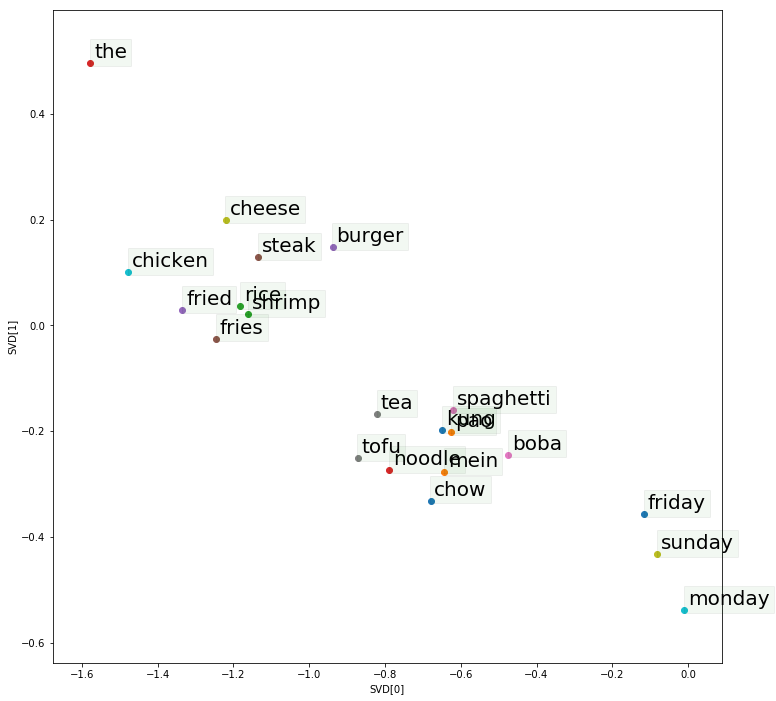

In [16]:
visualize_w2v(wordVectors, tokenDic, targetWords)

# Test Area

In [ ]:
sentences = []
with open("labeled_reviews .txt", "r", encoding='utf-8') as f:
    sentence = []
    for line in f:
        if line == '\n':
            sentences.append(sentence)
            sentence = []
        splitted = line.split()[:1]
        # Deal with some peculiar encoding issues with this file
        sentence += splitted

In [15]:
random.seed(314)
dataset = StanfordSentiment()
# convert tokens to dictionary
tokenDic = dataset.tokens()
nWords = len(tokenDic)

In [ ]:
sentences = []
with open("./stanfordSentimentTreebank" + "/datasetSentences.txt", "r", encoding='utf-8') as f:
    first = True
    for line in f:
        if first:
            first = False
            continue

        splitted = line.strip().split()[1:]
        # Deal with some peculiar encoding issues with this file
        sentences += [[w.lower() for w in splitted]]